In [232]:
%matplotlib inline

In [233]:
from skimage.io import collection, imread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import re
import glob

from datetime import datetime
import nltk

# How is the public opinion about a company correlated to it's market value?

A company's market value is variable and depends on a lot of factors. The price is a reflection of the company's perceived value - what the public is willing to pay for a piece of the company. It can and will rise and fall, based on a variety of factors in the global landscape and within the company itself. One of which is becoming more influential than ever - people's opinion on social media.

To analyze this correlation we'll look at two datasets. The first one contains over 3 million unique tweets with their information such as tweet id, author of the tweet, post date, the text body of the tweet, and the number of comments, likes, and retweets of tweets matched with the related company.

The second one will just have daily stock price records (from the Forbes2000) for us to make a reference with.

### 1. Data Acquisition 

So first let's read the tweets dataset into pandas and inspect a small sample from the two dataframes.

In [234]:
tweets = pd.read_csv('./top-companies-tweets/Tweet.csv')
tweets.sample(5)

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
528329,639029174020251648,stockwire24,1441191402,Uber IPO: Could This Stock Be the Next http://...,0,0,0
1102127,742561264296038400,computer_hware,1465875376,FIRST LOOK: What happened at #Apple's WWDC 201...,0,0,0
1605134,821799687988490240,It_c0nsulting,1484767288,#Google Agrees to Buy Twitter Unit Called Fabr...,0,0,0
1673584,832330991930843136,kem312,1487278147,More people listen to UBS than I could have ev...,0,0,0
1754129,851112705683357698,App_sw_,1491756056,#Microsoft's AI Driven Sprinkles to Take on Sn...,0,0,0


In [235]:
tweets_company = pd.read_csv('./top-companies-tweets/Company_Tweet.csv')
tweets_company.sample(5)

,tweet_id,ticker_symbol
166053,602453845273346048,AAPL
85837,575752943867056128,AAPL
4032037,1104856976805298178,TSLA
329158,665188957777432576,AAPL
1132338,1039523595616223232,AAPL


So next up let's read the datasets for each of the stocks, which we are monitoring. We will save them in a dictionary with the key, being the company's tick name and the value - it's stock prices over time dataset.

In [236]:
stocks_df = {}
for name in glob.glob('./stocks/*'):
    stocks_df[name.split('\\')[-1].split('.')[0]] = pd.read_csv(name)
stocks = pd.concat(stocks_df)
stocks.sample(10)

Date          Low         Open     Volume         High  \
AMZN 5981  22-02-2021  3172.260010  3208.129883    3515700  3232.320068   
AAPL 950   14-09-1984     0.123326     0.123326  246870400     0.127232   
MSFT 6610  29-05-2012    29.219999    29.379999   37758800    29.719999   
AMZN 1750  30-04-2004    43.310001    46.060001    9841300    46.349998   
AAPL 3849  05-03-1996     0.234375     0.236607  118440000     0.238839   
MSFT 6083  27-04-2010    30.750000    30.950001   68730900    31.250000   
TSLA 506   29-06-2012     6.200000     6.560000    5629000     6.560000   
AAPL 9170  25-04-2017    35.967499    35.977501   75486000    36.224998   
TSLA 2040  06-08-2018    68.363998    69.092003   42821500    70.996002   
     2752  04-06-2021   577.200012   579.710022   24036900   600.609985   

                 Close  Adjusted Close  
AMZN 5981  3180.739990     3180.739990  
AAPL 950      0.124442        0.097685  
MSFT 6610    29.559999       24.332476  
AMZN 1750    43.599998       43.599998  
AAPL 3849     0.237723        0.204419  
MSFT 6083    30.850000       24.028883  
TSLA 506      6.258000        6.258000  
AAPL 9170    36.132500       34.259430  
TSLA 2040    68.398003       68.398003  
     2752   599.049988      599.049988

### 2. Data Tidying and Cleaning

First let's combine the two tables from the twitter dataset, convert the dates to a datetime object and rename the column.

In [237]:
tweets = pd.merge(tweets, tweets_company, on = "tweet_id")

In [238]:
tweets["date"] = pd.to_datetime(tweets.post_date, unit='s')
tweets = tweets.drop(columns="post_date")
tweets.sample(5)


,tweet_id,writer,body,comment_num,retweet_num,like_num,ticker_symbol,date
3172649,1045061469023424512,SteveHamel16,Not $TSLA,0,0,3,TSLA,2018-09-26 21:24:05
2912769,1013816640142696448,wind4me,I'd LOVE to hear WHY $AMZN has gone #Hydrogen ...,0,0,0,AMZN,2018-07-02 16:08:17
1439505,768169604682248192,_GaganSandhu,your kidding right? $TSLA big news today was a...,0,0,0,TSLA,2016-08-23 19:34:40
89015,564836545320865792,IHNewsDesk,"$VGLT Recent News Updated Monday, February 9, ...",0,0,1,TSLA,2015-02-09 17:21:41
177970,576470074917134336,KymLang,$GOOGL little bounce off that .618,0,0,1,GOOGL,2015-03-13 19:49:10


We will see what timeframe does our dataset cover, by getting the data of the earliest and latest tweets.

In [239]:
tweets.date.min(), tweets.date.max()

(Timestamp('2015-01-01 00:00:57'), Timestamp('2019-12-31 23:55:53'))

So it has data from 01.01.2015 to 31.12.2019, so basically from 2015 to the beginning of 2020. Knowing this we can filter out the stock prices to be only in this period of time. But first we have to covert the "Date" column to datetime.

In [240]:
def string_to_date(date_string):
    return datetime.strptime(date_string, "%d-%m-%Y")
stocks.Date = pd.to_datetime(stocks.Date.apply(string_to_date))

In [241]:
stocks = stocks[(stocks.Date >= '01-01-2015') & (stocks.Date < '01-01-2020')]
stocks.sample(10)

Date          Low         Open     Volume         High  \
GOOG 3281 2017-08-30   919.650024   920.049988    1301200   930.818970   
     3095 2016-12-02   743.099976   744.590027    1452500   754.000000   
TSLA 1787 2017-08-03    68.629997    69.066002   67675000    70.000000   
AAPL 9406 2018-04-03    41.220001    41.910000  121112000    42.187500   
GOOG 3449 2018-05-02  1022.869995  1028.099976    1603100  1040.389038   
MSFT 7438 2015-09-14    42.860001    43.430000   23656000    43.439999   
GOOG 3532 2018-08-29  1236.359009  1237.449951    1298900  1250.660034   
     2974 2016-06-13   716.510010   716.510010    1258900   725.440002   
MSFT 7866 2017-05-25    68.910004    68.970001   21854100    69.879997   
AAPL 8783 2015-10-09    27.372499    27.500000  211064400    28.070000   

                 Close  Adjusted Close  
GOOG 3281   929.570007      929.570007  
     3095   750.500000      750.500000  
TSLA 1787    69.417999       69.417999  
AAPL 9406    42.097500       40.546650  
GOOG 3449  1024.380005     1024.380005  
MSFT 7438    43.040001       38.833099  
GOOG 3532  1249.300049     1249.300049  
     2974   718.359985      718.359985  
MSFT 7866    69.620003       65.742317  
AAPL 8783    28.030001       25.775946

As we can see we don't have data for every day, because the stock market functions only on workdays, unlike twitter.  We will find a way to work around this later.

Now lets strip the data down to just one column - the value, which we will calculate by getting the mean of the Open and Close prices. 

In [242]:
stocks["Value"] = (stocks.Open + stocks.Close) / 2
stocks = stocks.drop(columns=['Low', 'Open', 'High', 'Close', 'Adjusted Close'])
stocks.sample(10)

Date     Volume        Value
AAPL 9739 2019-07-30  135742800    52.192499
     8993 2016-08-10   96034000    27.088750
TSLA 1138 2015-01-06   31309500    42.134001
AAPL 9236 2017-07-28   68854800    37.423750
TSLA 2043 2018-08-09   85919000    71.799999
GOOG 3751 2019-07-16    1238800  1149.789978
TSLA 1864 2017-11-21   36306500    62.867001
     1654 2017-01-24   24827500    50.461000
AMZN 5111 2017-09-06    2129900   968.059998
MSFT 8015 2017-12-27   14678000    85.680000

It is a little inconvenient to have the stock name as an index instead of it being a regular column. We will fix that and also change the column names to match the twitter dataset.

In [243]:
stocks = stocks.reset_index(level=0)

In [244]:
stocks.columns = ["ticker_symbol", "date", "volume", "value"]
stocks.sample(10)
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6290 entries, 8589 to 2393
Data columns (total 4 columns):
ticker_symbol    6290 non-null object
date             6290 non-null datetime64[ns]
volume           6290 non-null int64
value            6290 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 245.7+ KB


 So next up lets take a look at the datatypes and null values for the twitter dataset.

In [245]:
tweets.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4336445 entries, 0 to 4336444
Data columns (total 8 columns):
tweet_id         4336445 non-null int64
writer           4280526 non-null object
body             4336445 non-null object
comment_num      4336445 non-null int64
retweet_num      4336445 non-null int64
like_num         4336445 non-null int64
ticker_symbol    4336445 non-null object
date             4336445 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 297.8+ MB


Everything looks good, except the ticker_symbol which should be a category. Also the writer column has quite a few missing records, but we won't be using it for our model and analysis, so we can discard it altogether.

In [246]:
tweets.ticker_symbol = tweets.ticker_symbol.astype('category')
tweets = tweets.drop(columns=["writer"])
tweets.head(7)

,tweet_id,body,comment_num,retweet_num,like_num,ticker_symbol,date
0,550441509175443456,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL,2015-01-01 00:00:57
1,550441672312512512,Insanity of today weirdo massive selling. $aap...,0,0,0,AAPL,2015-01-01 00:01:36
2,550441732014223360,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,AMZN,2015-01-01 00:01:50
3,550442977802207232,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,TSLA,2015-01-01 00:06:47
4,550443807834402816,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,2015-01-01 00:10:05
5,550443807834402816,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,TSLA,2015-01-01 00:10:05
6,550443808606126081,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,2015-01-01 00:10:05


As we can see there seem to be a lot of duplicate bodies in our dataset. We want to remove them and this is exactly what the following code does. 

In [247]:
tweets = tweets.drop_duplicates(subset=["body"])

### 3. Text Preparation and Exploration

Before we start working with the text, we have to prepare it and take a quick look at some statistics about it. First let's convert all the tweets' bodies into lowercase.

In [248]:
tweets.body = tweets.body.str.lower()

Before we separate the tweets into words, we want to remove any urls from them.

In [249]:
url_regex = r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'
def remove_url_from_string(str):
    return re.sub(url_regex, '', str)
tweets.body = tweets.body.apply(remove_url_from_string)

NLTK provides a small corpus of stop words that we will load into a list, based on which we'll later filter them out from the tweets.

In [250]:
stopwords = nltk.corpus.stopwords.words("english")
stopwords.append("")

To properly analyze the text for starters we would like to split it into single words and remove all the stopwords from it. Later on we would like to apply some sort of sentiment analysis, which works on whole texts, not lists of words, so we will save the "tokenized" version into a new variable, which we can work with.

In [252]:
def string_into_words(str): 
    return [w for w in re.split("\W+", str) if w not in stopwords]

tokenized_tweets = tweets.body.apply(string_into_words).copy()
tokenized_tweets.sample(5)

1899292    [reasons, apple, hot, manufacture, india, asia...
1195426    [apple, ceo, tim, cook, visit, india, meet, pm...
4013811                                     [new, lod, aapl]
4275747    [piper, jaffray, increases, price, target, tsl...
1150121    [someone, sleep, sleeping, pill, tim, cook, co...
Name: body, dtype: object

Now we can look at the frequency distribution of the words (how many times is each word appears in the tweets). Just because the dataset is too large to analyze every observation. To combat this we will take a smaller sample of the data.

In [253]:
tweets_sample = tokenized_tweets.sample(10000, random_state=10)
tweets_sample.head(3)

1362011    [mobileye, drops, 10, ends, tesla, relationshi...
3439937    [50, dma, resistance, today, kiq, vips, ntes, ...
2974882    [active, traders, try, one, free, trading, gui...
Name: body, dtype: object

In [254]:
all_words = tweets_sample.sum()

In [255]:
fd = nltk.FreqDist(all_words)

In [256]:
common_words = np.array(fd.most_common(30))
common_words

array([['aapl', '4063'],
       ['tsla', '3131'],
       ['amzn', '2239'],
       ['apple', '1487'],
       ['read', '1257'],
       ['goog', '1116'],
       ['msft', '1059'],
       ['googl', '985'],
       ['fb', '806'],
       ['stock', '708'],
       ['tesla', '707'],
       ['stocks', '560'],
       ['google', '545'],
       ['nflx', '536'],
       ['microsoft', '510'],
       ['new', '497'],
       ['inc', '491'],
       ['amazon', '486'],
       ['spy', '473'],
       ['like', '459'],
       ['1', '458'],
       ['market', '390'],
       ['today', '381'],
       ['3', '378'],
       ['buy', '358'],
       ['iphone', '351'],
       ['get', '350'],
       ['day', '336'],
       ['trading', '335'],
       ['2', '328']], dtype='<U9')

We can plot this data with a bar chart.

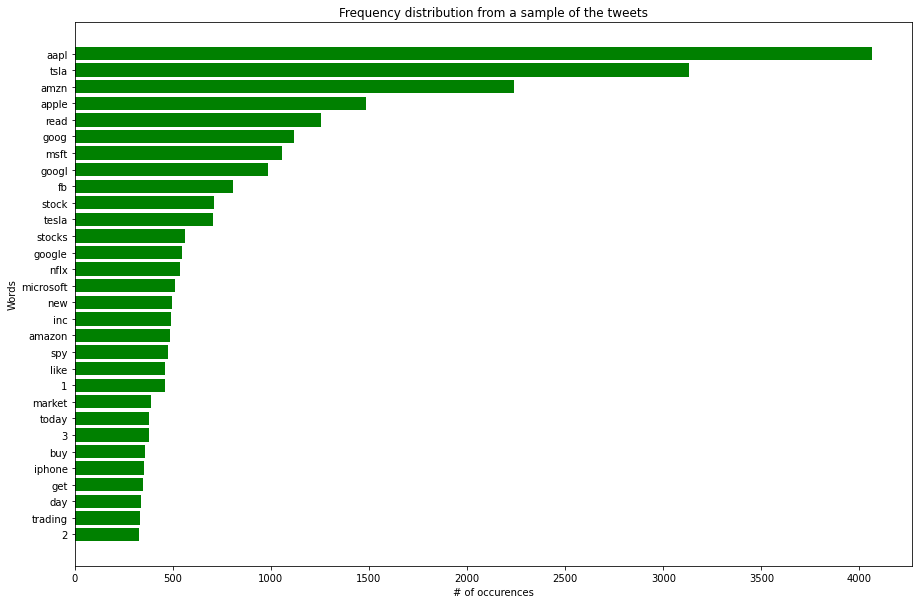

In [257]:
common_words = np.flip(common_words, axis=0)
bar_words = common_words[:, 0]
bar_occu = common_words[:, 1].astype(int)
bar_x = [i for i, _ in enumerate(bar_words)]

plt.figure(figsize=(15, 10))
plt.barh(bar_x, bar_occu, color='green')
plt.xlabel("# of occurences")
plt.ylabel("Words")
plt.title("Frequency distribution from a sample of the tweets")

plt.yticks(bar_x, bar_words)

plt.show()

The first 30 words consist mainly of companies' names and stock ticks as we can expect. But at the bottom there we can see words like \"like\" and "buy". This is very important, because they express some sort of sentiment.

### 4. Hypotheses

There are two main ways that social media could affect the market.
   1. The overall **amount of tweets** about a company raises the interest in its stocks, which results into more transactions being made (positions being closed and opened). The metric which tracks how much a stock is being traded is called **"Trading Volume"**. We can look for a correlation between the traded volume of a stock and how much people "talked" about it the previous day. 
       * The **null hypothesis** here is: There is *no correlation* between the amount of tweets about a company with the volume of its stock traded the following day.
       * And the **alternate hypothesis**: The *is a correlation* between the amount of tweets about a company with the volume of its stock traded the following day.


   2. Another important detail is what actually we're the people saying. In other words we would like to know if the general public opinion correlates in some way with the price's fluctuation. And what I mean by public opinion is whether the majority of the statements about a company made *online* are **positive or negative**. We will look at the correlation of the **average sentiment** of all tweets about a company and its **stock price** the following day.
       * **Null hypothesis**: There is *no correlation* between the ratio of positive/negative tweets about a company with the price of its stock on the same day.
       * And the **alternate hypothesis**: There *is a correlation* between the ratio of positive/negative tweets about a company with the price of its stock on the same day.

To test the our hypotheses we can use a correlation coefficient. The most common of these are the *Pearson correlation coefficient* and the *Spearman's rank correlation*. The first one is sensitive only to a linear relationship between two variables, which is not what we are looking for. The *Spearman's rank correlation coefficient* however is a lot more robust (sensitive to *non-linear relationships*) than Pearson's. That is why we will use it for this project.

In [258]:
tweets

,tweet_id,body,comment_num,retweet_num,like_num,ticker_symbol,date
0,550441509175443456,"lx21 made $10,008 on $aapl -check it out! le...",0,0,1,AAPL,2015-01-01 00:00:57
1,550441672312512512,insanity of today weirdo massive selling. $aap...,0,0,0,AAPL,2015-01-01 00:01:36
2,550441732014223360,s&p100 #stocks performance $hd $low $sbux $tgt...,0,0,0,AMZN,2015-01-01 00:01:50
3,550442977802207232,$gm $tsla: volkswagen pushes 2014 record recal...,0,0,1,TSLA,2015-01-01 00:06:47
4,550443807834402816,swing trading: up to 8.91% return in 14 days ...,0,0,1,AAPL,2015-01-01 00:10:05
6,550443808606126081,swing trading: up to 8.91% return in 14 days ...,0,0,1,AAPL,2015-01-01 00:10:05
8,550443809700851716,swing trading: up to 8.91% return in 14 days ...,0,0,1,AAPL,2015-01-01 00:10:05
10,550443857142611968,swing trading: up to 8.91% return in 14 days ...,0,0,1,AAPL,2015-01-01 00:10:16
12,550443857595600896,swing trading: up to 8.91% return in 14 days ...,0,0,1,AAPL,2015-01-01 00:10:17
14,550443857692078081,swing trading: up to 8.91% return in 14 days ...,0,0,1,AAPL,2015-01-01 00:10:17
